### Perform Imports

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from keras import backend as K
from keras.layers import Conv2D, Dropout, LSTM, BatchNormalization, Input,Activation, MaxPool2D, Flatten, Dense,TimeDistributed
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import ZeroPadding2D
from keras import metrics
import h5py
from sklearn.metrics import confusion_matrix
from utils import *
from data_utils import *
from models import *

/home/sudeep/.conda/envs/keras_gpu_tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
VIDEOS_DIR, IMAGES_DIR, classes, class_to_index, videos = get_global_variables()
print(VIDEOS_DIR)
print(IMAGES_DIR)
print(classes)
print(class_to_index)
print(videos)

../Videos/
../Images/
['Kicking', 'Riding-Horse', 'Running', 'SkateBoarding', 'Swing-Bench', 'Lifting', 'Swing-Side', 'Walking', 'Golf-Swing']
{'Kicking': 0, 'Riding-Horse': 1, 'Running': 2, 'SkateBoarding': 3, 'Swing-Bench': 4, 'Lifting': 5, 'Swing-Side': 6, 'Walking': 7, 'Golf-Swing': 8}
[['014', '009', '005', '011', '010', '003', '012', '006', '013', '004', '016', '001', '007', '002', '017', '015'], ['009', '005', '010', '003', '006', '004', '001', '007', '008', '002'], ['009', '005', '010', '006', '004', '001', '007', '008', '002'], ['009', '005', '010', '003', '006', '004', '001', '007', '008', '002'], ['014', '009', '005', '011', '010', '003', '012', '006', '013', '004', '016', '001', '007', '008', '002', '017', '015'], ['005', '003', '004', '001', '002'], ['009', '005', '011', '010', '003', '006', '004', '001', '007', '008', '002'], ['014', '009', '005', '011', '010', '018', '003', '012', '006', '013', '004', '016', '001', '019', '007', '008', '002', '017', '015'], ['014', '009'

In [3]:
X_train, Y_train, X_test, Y_test = build_dataset_end_to_end((172, 172))

In [4]:
X_train.shape, X_test.shape,Y_train.shape, Y_test.shape

((340, 40, 172, 172, 3), (22,), (340,), (22,))

Walking


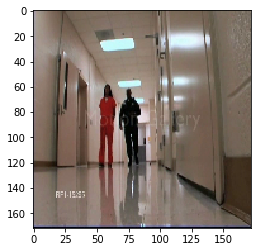

In [17]:
x = np.random.randint(340)
plt.imshow(X_train[x, 0])
print(classes[Y_train[x]])

In [20]:
e2e = end_to_end((40, 172, 172, 3))

In [21]:
e2e.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 40, 172, 172, 0                                            
__________________________________________________________________________________________________
BatchNorm_1 (TimeDistributed)   (None, 40, 172, 172, 12          input_2[0][0]                    
__________________________________________________________________________________________________
Conv_1a (TimeDistributed)       (None, 40, 43, 43, 3 4736        BatchNorm_1[0][0]                
__________________________________________________________________________________________________
Conv_1b (TimeDistributed)       (None, 40, 43, 43, 3 9248        Conv_1a[0][0]                    
__________________________________________________________________________________________________
Pool_1 (Ti

In [34]:
e2e.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.5],
        metrics=['accuracy'],
        optimizer='adam')

In [44]:
X_train, Y_train = permute(X_train, Y_train)

In [45]:
X_train.shape

(340, 40, 172, 172, 3)

In [46]:
Y_train = convert_to_one_hot(Y_train, 9)


In [47]:
Y_train.shape

(340, 9)

In [48]:
Y_train2 = np.tile(Y_train, (40, 1, 1))

In [49]:
Y_train2 = Y_train2.transpose(1, 0, 2)


In [50]:
Y_train2.shape

(340, 40, 9)

#### Generator Testing

In [16]:
def generate_batch_data(batch_size):
    X_train = np.load('../Numpy/End2End/X_train.npy')
    Y_train = np.load('../Numpy/End2End/Y_train.npy')
    
    Y_train = convert_to_one_hot(Y_train,9)
    
    X_train, Y_train = permute(X_train, Y_train)
    
    Y_train2 = np.tile(Y_train, (40, 1, 1))
    Y_train2 = Y_train2.transpose(1, 0, 2)

    samples = X_train.shape[0]
    while 1:
        i = 0
        for i in range(samples):
            X_batch = X_train[i:i+batch_size]
            Y_batch = Y_train[i:i+batch_size]
            Y_batch_2 = Y_train2[i:i+batch_size]
            yield X_batch,{'final_1' : Y_batch_2, 'final_2' : Y_batch}

In [17]:
import math
X_train = np.load('../Numpy/End2End/X_train.npy')
steps = math.ceil(X_train.shape[0]/10)

In [42]:
e2e.fit_generator(generate_batch_data(10), steps_per_epoch=steps, epochs=10, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=2, use_multiprocessing=True, shuffle=True, initial_epoch=0)

/home/shreyas/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
35/35 [==============================] - 24s 698ms/step - loss: 0.9867 - final_2_loss: 0.6081 - final_1_loss: 0.7573 - final_2_acc: 0.8143 - final_1_acc: 0.7704
Epoch 2/10
35/35 [==============================] - 25s 719ms/step - loss: 1.4589 - final_2_loss: 0.7886 - final_1_loss: 1.3406 - final_2_acc: 0.7257 - final_1_acc: 0.5996
Epoch 3/10
35/35 [==============================] - 28s 806ms/step - loss: 1.1146 - final_2_loss: 0.6124 - final_1_loss: 1.0044 - final_2_acc: 0.8343 - final_1_acc: 0.6729
Epoch 4/10
35/35 [==============================] - 34s 972ms/step - loss: 0.9630 - final_2_loss: 0.5585 - final_1_loss: 0.8090 - final_2_acc: 0.8257 - final_1_acc: 0.7343
Epoch 5/10
35/35 [==============================] - 38s 1s/step - loss: 1.0320 - final_2_loss: 0.5778 - final_1_loss: 0.9084 - final_2_acc: 0.8257 - final_1_acc: 0.7506
Epoch 6/10
35/35 [==============================] - 38s 1s/step - loss: 0.7992 - final_2_loss: 0.3968 - final_1_loss: 0.8048 - final_2_acc: 0.8

## Training

In [18]:
result = evaluate(e2e,X_test,Y_test,verbose=False)
print(result)

13.636363636363635


In [121]:
e2e = load_model('../models/End_End/temp0_ke_baad_3_epoch_phir_ulta_weights.h5')

In [122]:
e2e.loss_weights = [0.8, 1]

In [123]:
e2e.loss_weights

[0.8, 1]

In [124]:
ten = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=64, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
e2e.fit(X_train, [Y_train, Y_train2], 
              epochs = 2, 
              batch_size = 64, 
              validation_split = 0.1,
              callbacks=[ten])

Train on 306 samples, validate on 34 samples
Epoch 1/2
306/306 [==============================] - 146s 477ms/step - loss: 0.5248 - dense_1_loss: 0.1052 - time_distributed_14_loss: 0.4827 - dense_1_acc: 0.9869 - time_distributed_14_acc: 0.8484 - val_loss: 0.3415 - val_dense_1_loss: 0.0709 - val_time_distributed_14_loss: 0.3131 - val_dense_1_acc: 1.0000 - val_time_distributed_14_acc: 0.9559
Epoch 2/2
306/306 [==============================] - 156s 509ms/step - loss: 0.4978 - dense_1_loss: 0.0969 - time_distributed_14_loss: 0.4591 - dense_1_acc: 0.9935 - time_distributed_14_acc: 0.8615 - val_loss: 0.3202 - val_dense_1_loss: 0.0650 - val_time_distributed_14_loss: 0.2941 - val_dense_1_acc: 1.0000 - val_time_distributed_14_acc: 0.9551


In [117]:
e2e.save('../models/End_End/temp0_ke_baad_3_epoch_phir_ulta_weights.h5')

## Testing

In [2]:
X_test_unseen, Y_test_unseen = build_test_dataset(image_size=(172, 172), stride = 10, max_len = 40, train = False)

Processed 010 of class Kicking
Processed 006 of class Kicking
Processed 004 of class Kicking
Processed 008 of class Kicking
Processed 011 of class Riding-Horse
Processed 012 of class Riding-Horse
Processed 012 of class Running
Processed 011 of class SkateBoarding
Processed 012 of class SkateBoarding
Processed 018 of class Swing-Bench
Processed 020 of class Swing-Bench
Processed 019 of class Swing-Bench
Processed 006 of class Lifting
Processed 012 of class Swing-Side
Processed 013 of class Swing-Side
Processed 021 of class Walking
Processed 020 of class Walking
Processed 022 of class Walking
Processed 009 of class Golf-Swing
Processed 005 of class Golf-Swing
Processed 007 of class Golf-Swing
Processed 008 of class Golf-Swing


In [3]:
X_test_unseen.shape, Y_test_unseen.shape

((22,), (22,))

In [3]:
X_test_full, Y_test_full = build_test_dataset(image_size=(172, 172), stride = 10, max_len = 40, train = True)

In [5]:
X_test_full.shape, Y_test_full.shape

((111,), (111,))

In [8]:
e2e = load_model('../models/End_End/temp0_ke_baad_3_epoch_phir_ulta_weights.h5')
print(evaluate(e2e, X_test_full, Y_test_full, verbose=False))

95.4954954954955


In [126]:
print(res_norm,res_un)

63.63636363636363 90.9090909090909


In [133]:
for i in os.listdir('../models/End_End/'):
    if i[-3:] == '.h5'and i[:5] == 'temp0':
        mod_16 = load_model('../models/End_End/' + i)
        res_un = evaluate(mod_16, X_test_unseen, Y_test_unseen,verbose=False)
        res_norm = evaluate(mod_16, X_test, Y_test, verbose=False)
        res_f = evaluate(mod_16, X_test_full, Y_test_full, verbose=False)
        print(i,res_un,res_norm,res_f)
        print(i, res_f)

temp0_ke_baad_3_epoch_phir_ulta_weights.h5 95.4954954954955
temp0.h5 90.990990990991
temp0_ke_baad_3_epoch.h5 95.4954954954955
